In [148]:
from data_loader import data_reader, colnames, colnames_bid
from matplotlib import pyplot as plt
import math
import pandas as pd
import numpy as np

In [91]:
#DONT FORGET TO LOAD THAT OTHER FUCKING DATASET, I KNOW YOU ARE LAZY
# BUT JUST DONT FORGET IT
# YEAH, SURE, NO PROBLEM
# YOU CAN DO IT LATER
# JUST DONT FORGET IT

imp = data_reader('data\\imp.20131020.txt', colnames, 
                verbose=False, fuck_parsing=True)
bid = data_reader('data\\bid.20131020.txt', colnames_bid, verbose=False, fuck_parsing=True)
clk = data_reader('data\\clk.20131020.txt', colnames, verbose=False, fuck_parsing=True)
conv = data_reader('data\\conv.20131020.txt', colnames, verbose=False, fuck_parsing=True)


In [106]:
bid_rel = bid[['bid_id', 'timestamp']]
imp_rel = imp[['bid_id', 'paying_price']]
# clk_rel = clk[['bid_id', 'paying_price']]
# conv_rel = conv[['bid_id', 'paying_price']]
bids = bid_rel.merge(imp_rel,how='left', on='bid_id').sort_values('timestamp')
bids['not_bought'] = [math.isnan(price) for price in bids.paying_price]
bids.paying_price = bids.paying_price.fillna(0)

In [169]:
def split_explore_exploit(bids, share_exploration):
    N = bids.shape[0]
    this_many = int(share_exploration * N)
    bids_explore = bids.iloc[:this_many, :]
    bids_exploit = bids.iloc[this_many:, :]
    return bids_explore, bids_exploit, N

share_exploration = 0.003
bids_explore, bids_exploit, N = split_explore_exploit(bids, share_exploration)

G = 1e5 / 2
B = 6e6 / 2
target_price =  B/G
target_winrate = G / N




print(bids_explore.shape)
print(target_price)
print(target_winrate)

(981, 4)
60.0
0.15285705114291218


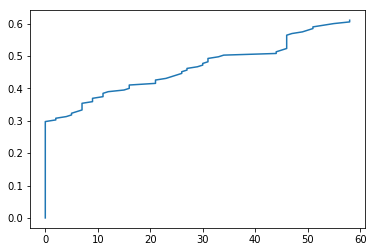

0.6122448979591837
14.191666666666666
doubling


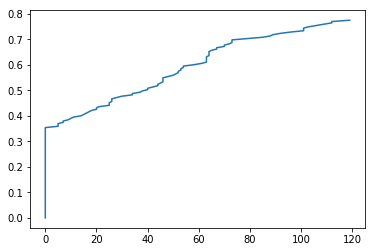

0.7755102040816326
28.111842105263158
doubling


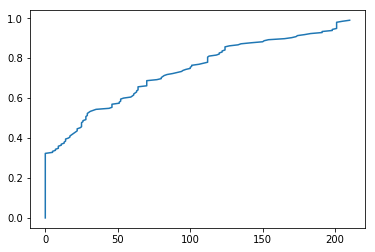

0.9897959183673469
54.608247422680414
doubling


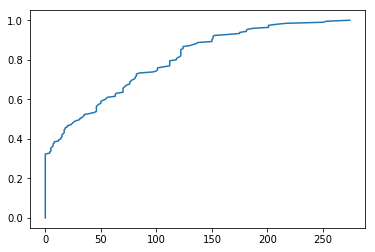

1.0
55.46938775510204
doubling


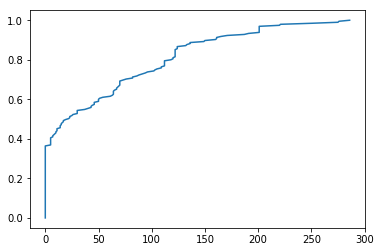

1.0
55.15816326530612
doubling


In [167]:
def explore(bids_explore, target_price, N, rounds=5, plot_win_fct=False):
    bid_price = target_price
    N_expl = bids_explore.shape[0]
    step = int(N_expl / rounds)
    start = 0
    stop = step
    for round in range(rounds):
        won = 0
        cost = 0
        winning_prices = [np.nan] * step
        index=0
        for _, bid in bids_explore \
                            .iloc[start:stop, :] \
                            .iterrows():
            if bid_price > bid.paying_price:
                won += 1
                cost += bid.paying_price
                winning_prices[index] = bid.paying_price
            index += 1
        if plot_win_fct:
            sorted_data = np.sort(winning_prices)
            yvals=np.arange(len(winning_prices))/float(len(winning_prices)-1)
            plt.plot(sorted_data, yvals)
            plt.show()
        winrate = won / step
        price = cost / won
        exp_views = N * winrate
        exp_price = cost / step
        
        if  (exp_views < G) or (price < target_price):
            bid_price = bid_price * 2
            print(winrate)
            print(price)
            print('doubling')
        else:
            print('breaking in round %s' % round)
            print('E(views): %.2f > target_views %.2f' % \
                  (exp_views, G))
            print('E(price): %.2f > target_price %.2f' % \
                  (exp_price, target_price))
            break
        start += step
        stop += step
    return winning_prices
abc = explore(bids_explore, target_price, N, plot_win_fct = True)


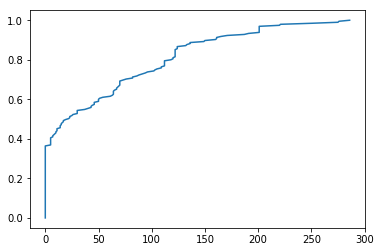

In [170]:
sorted_data = np.sort(abc)
yvals=np.arange(len(abc))/float(len(abc)-1)
plt.plot(sorted_data,yvals)
plt.show()

In [179]:
counts = pd.Series(sorted_data).value_counts(normalize=True, sort=False, dropna=False)
sorted_data=pd.DataFrame(sorted_data)

TypeError: 'numpy.int64' object is not iterable

In [185]:
sorted_data.columns = ['values']

In [204]:

counts=pd.DataFrame(counts)
for_b_B = sorted_data.merge(counts, left_on='values', right_index=True)

In [208]:
for_b_B.columns = ['vals', 'freq']

In [217]:
abc = for_b_B

array([  0.,   5.,   7.,   8.,   9.,  10.,  11.,  14.,  15.,  16.,  17.,
        19.,  22.,  23.,  25.,  26.,  30.,  37.,  40.,  43.,  44.,  46.,
        50.,  51.,  54.,  61.,  63.,  64.,  65.,  67.,  68.,  69.,  70.,
        73.,  76.,  82.,  86.,  88.,  91.,  94.,  96., 102., 103., 105.,
       109., 112., 118., 120., 122., 124., 132., 133., 136., 149., 150.,
       160., 161., 165., 171., 187., 191., 201., 220., 221., 250., 275.,
       276., 286.])